In [1]:
# All imports
from Imports import *
from Preprocessing import *
from Helper import *
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# Load dataset and device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data paths
TRAIN_FILE = '../Data/2025-Quantathon-Tornado-Q-training_data-640-examples.xlsx'
TEST_FILE = '../Data/2025-Quantum-Tornado-Q-test_data-200-examples.xlsx'
VALIDATION_FILE = '../Data/2025-Quantum-Tornado-validation_data-160-examples.xlsx'

# Load training data
df_train = pd.read_excel(TRAIN_FILE)
# Load test data
df_test = pd.read_excel(TEST_FILE)
# Load validation data
df_val = pd.read_excel(VALIDATION_FILE)

if True:
    # Quantum augmented datasets using random shadows
    EXTRA_TRAIN = "../Data/36_featuresXY_train_QuantumLayers3.csv"
    EXTRA_TEST  = "../Data/36_featuresXY_test_QuantumLayers3.csv"
    EXTRA_VALID = "../Data/36_featuresXY_val_QuantumLayers3.csv"
    
    # Extra features
    extra_train_df = pd.read_csv(EXTRA_TRAIN)
    extra_test_df = pd.read_csv(EXTRA_TEST)
    extra_valid_df = pd.read_csv(EXTRA_VALID)
    
    # Drop first column by index
    extra_train_df = extra_train_df.drop(extra_train_df.columns[0], axis=1)
    extra_test_df = extra_test_df.drop(extra_test_df.columns[0], axis=1)
    extra_valid_df = extra_valid_df.drop(extra_valid_df.columns[0], axis=1)
    
    # Concatenate extra features (axis=1 for columns)
    df_train = pd.concat([df_train, extra_train_df], axis=1)
    df_test  = pd.concat([df_test, extra_test_df], axis=1)
    df_val  = pd.concat([df_val, extra_valid_df], axis=1)
    
for i, row in df_train.head(3).iterrows():
    print(row.tolist())

print(f"✓ Training data loaded: {df_train.shape[0]} rows, {df_train.shape[1]} columns")
print(f"✓ Test data loaded: {df_test.shape[0]} rows, {df_test.shape[1]} columns")

[4207.767578125, 192.0945587158203, 294.7670288085937, 299.4913330078125, 33.25276184082031, 99651.6875, 10.141384342896378, 22.539603047233594, 1.0, 0.0, 0.5613480779355768, 0.0683414043583638, 0.4772182254198469, 0.3453041105537409, 0.2439598737813071, 0.3617257318951203, 0.405998178123383, 0.148769371011852, 0.4866487988882397, 0.648793232147284, 0.1761976358357628, 0.5684840425531661, 0.3817091998910769, 0.2532053411279946, 0.4840546697038519, 0.5982676840586123, 0.6232965606748166, 0.5685251304586814, 0.3906160663236022, 0.3509913258984056, 0.6662361963998507, 0.6114294484805782, 0.3394448916316008, 0.8454709959370632, 0.4101927594422179, 0.2721539697177206, 0.2777780295888306, 0.3962814194418342, 0.5578513112463526, 0.5393061950686331, 0.5830423230084989, 0.5405401128490581, 0.5860204082689933, 0.5103875441110759, 0.8481179136377222]
[87.97427368164062, 317.01123046875, 290.7364501953125, 304.0491943359375, 20.088348388671875, 92164.1875, 0.0089225431647932, 6.829328485761937, 0.

In [3]:
# Binary DN without Quantum Layer
class BinaryDNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Encodes features from dataset
        self.feature_encoder = nn.Sequential(
            nn.Linear(43, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2)
            # nn.Linear(128, 1024),
            # nn.LeakyReLU(0.2),
            # nn.Dropout(0.2),
        )

        # Classifies based on encoded features
        self.classifier = nn.Sequential(
            # nn.Linear(1024, 128),
            # nn.LeakyReLU(0.2),
            # nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(64, 4)
        )

    def forward(self, features):
        feats_encoded = self.feature_encoder(features)
        class_target = self.classifier(feats_encoded)

        return class_target  # Shape: (batch_size, 4)

In [4]:
# Define variable and dataset
batch_size = 64
lr = 1e-2

X_train, y_train, X_test, y_test, X_val, y_val = Preprocess(df_train, df_test, df_val, balance = 'smote', classes = 'multiclass')

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

print(y_test[:])
print(y_train[:])
print(y_val[:])

train_data = ClassificationDataset(X_train, y_train)
validation_data = ClassificationDataset(X_val, y_val)
test_data = ClassificationDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(validation_data, batch_size=64, shuffle=False, drop_last=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, drop_last=True)

X_batch, y_batch = next(iter(train_loader))

print("Batch X dtype:", X_batch.dtype)
print("Batch y dtype:", y_batch.dtype)

print("Number of training samples:", len(train_data))
print("Number of validation samples:", len(validation_data))
print("Number of test samples:", len(test_data))

(1328, 43) (1328,)
(160, 43) (160,)
(200, 43) (200,)
0      1
1      0
2      1
3      0
4      2
      ..
195    1
196    1
197    3
198    0
199    0
Name: ef_class, Length: 200, dtype: int64
0       1
1       0
2       1
3       0
4       1
       ..
1323    3
1324    3
1325    3
1326    3
1327    3
Name: ef_class, Length: 1328, dtype: int64
0      0
1      1
2      2
3      0
4      0
      ..
155    0
156    1
157    0
158    0
159    1
Name: ef_class, Length: 160, dtype: int64
Batch X dtype: torch.float32
Batch y dtype: torch.float32
Number of training samples: 1328
Number of validation samples: 160
Number of test samples: 200


In [5]:
# Initialize model, optimizer, and scheduler
n_epochs = 1000

DNN = BinaryDNN().to(device)
optimizer = optim.Adam(DNN.parameters(), lr=lr, betas=(0.9, 0.999))
scheduler_G = CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=1e-4)

# Empty array to track losses
losses = []

In [6]:
# # Plot visual of DNN
# graph =  draw_graph(
#     DNN,
#     input_size=(1, 8),
#     expand_nested=True,
#     depth = 1,
#     graph_name="DNN Architecture",
#     mode = 'train',
#     show_shapes = True,
#     hide_inner_tensors=True,   # Hides intermediate shapes
#     roll=True,                  # More compact layer grouping
#     save_graph=False,           # Set to True if you want to save
#     # node_attr={"color": "lightblue", "style": "filled"},  # Node styling
#     # edge_attr={"color": "gray"},                          # Edge styling
#     graph_dir= "TB",                         # Layout: TB (top-bottom), LR (left-right)
# )

# # Show in notebook
# graph.visual_graph

In [7]:
## Load a previous model
load = False

if load:
    # load_path = "models/Binary_DNN_" # Path to load model
    
    # Load the checkpoint
    checkpoint = torch.load(load_path)
    
    # Restore model weights
    DNN.load_state_dict(checkpoint["DNN_state_dict"])
    
    # Optionally restore tracking data
    losses = checkpoint["losses"]
        
    print(f"Loaded model from {load_path}")

In [8]:
cross_entropy = nn.CrossEntropyLoss()
metric = lambda outputs, target: (torch.argmax(outputs, dim=1) == target).float().mean().item()
best_val_metric = 0
best_val_loss = 999

history = {'epoch': [], 'train_loss': [], 'train_metric': [], 'val_loss': [], 'val_metric': []}

for epoch in range(n_epochs):
    DNN.train()
    train_loss, train_metric = 0.0, 0.0

    for features, target in train_loader:
        features, target = features.to(device), target.to(device).long()  # targets shape: (batch_size,)

        optimizer.zero_grad()
        outputs = DNN(features)              # logits: (batch_size, num_classes)
        loss = cross_entropy(outputs, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_metric += metric(outputs, target)

    train_loss /= len(train_loader)
    train_metric /= len(train_loader)

    # Validation
    DNN.eval()
    val_loss, val_metric = 0.0, 0.0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device).long()
            outputs = DNN(X_val)
            val_loss += cross_entropy(outputs, y_val).item()
            val_metric += metric(outputs, y_val)

    val_loss /= len(val_loader)
    val_metric /= len(val_loader)

    history['epoch'].append(epoch)
    history['train_loss'].append(train_loss)
    history['train_metric'].append(train_metric)
    history['val_loss'].append(val_loss)
    history['val_metric'].append(val_metric)

    if epoch % 10 == 9:
        print(f'Epoch [{epoch+1}/{n_epochs}] | Train Loss: {train_loss:.4f} | '
              f'Train Acc: {train_metric:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_metric:.4f}')

    # Save best model (accuracy)
    if val_metric > best_val_metric:
        best_val_metric = val_metric
        os.makedirs("models", exist_ok=True)
        save_path = "models/DNN_multiclass_best_accuracy.pt"
        torch.save({"DNN_state_dict": DNN.state_dict(), "history": history}, save_path)
        print(f'Epoch [{epoch+1}] had best val_metric')
        

    # Save best model (val loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        os.makedirs("models", exist_ok=True)
        save_path = "models/DNN_multiclass_best_valLoss.pt"
        torch.save({"DNN_state_dict": DNN.state_dict(), "history": history}, save_path)
        print(f'Epoch [{epoch+1}] had best val loss')
        


Epoch [1] had best val_metric
Epoch [1] had best val loss
Epoch [2] had best val_metric
Epoch [2] had best val loss
Epoch [10/1000] | Train Loss: 1.2329 | Train Acc: 0.4344 | Val Loss: 1.5185 | Val Acc: 0.1719
Epoch [20/1000] | Train Loss: 1.1019 | Train Acc: 0.5055 | Val Loss: 1.4199 | Val Acc: 0.3203
Epoch [22] had best val loss
Epoch [30/1000] | Train Loss: 1.0055 | Train Acc: 0.5430 | Val Loss: 1.2281 | Val Acc: 0.4766
Epoch [31] had best val loss
Epoch [37] had best val loss
Epoch [40/1000] | Train Loss: 0.9641 | Train Acc: 0.5484 | Val Loss: 1.2802 | Val Acc: 0.4922
Epoch [43] had best val loss
Epoch [45] had best val loss
Epoch [50/1000] | Train Loss: 0.9042 | Train Acc: 0.5969 | Val Loss: 1.0713 | Val Acc: 0.5078
Epoch [50] had best val loss
Epoch [57] had best val_metric
Epoch [57] had best val loss
Epoch [60/1000] | Train Loss: 0.8516 | Train Acc: 0.6172 | Val Loss: 1.2465 | Val Acc: 0.4375
Epoch [70/1000] | Train Loss: 0.8876 | Train Acc: 0.6117 | Val Loss: 1.2839 | Val Acc:

In [9]:
## Save Model
# Create output directory if it doesn't exist

save = True
if save:
    os.makedirs("models", exist_ok=True)
    
    # Timestamp for unique filenames
    timestamp = datetime.now().strftime("%m%d_%H%M")
    
    # Save model states and tracked data in a single file
    save_path = f"models/Multiclass_DNN_3Layer_AUC.8.best_{timestamp}.pt"
    torch.save({
        "DNN_state_dict": DNN.state_dict(),
        "losses": losses,
    }, save_path)
    
    print(f"Model and statistics saved to {save_path}")

Model and statistics saved to models/Multiclass_DNN_3Layer_AUC.8.best_1011_1053.pt


AUC: 0.6216, F1: 0.2894, Accuracy: 0.5781
Class 0 CSI: 0.5294
Class 1 CSI: 0.3030
Class 2 CSI: 0.0000
Class 3 CSI: 0.0000


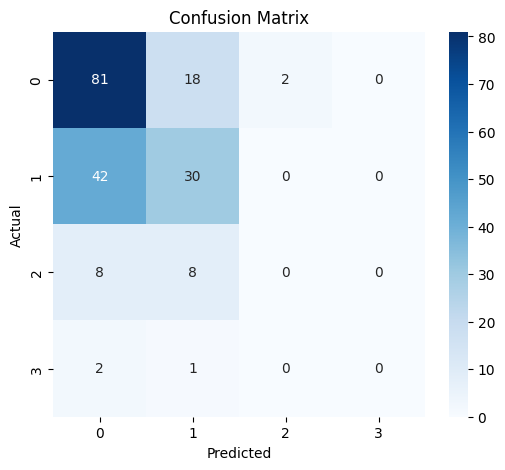

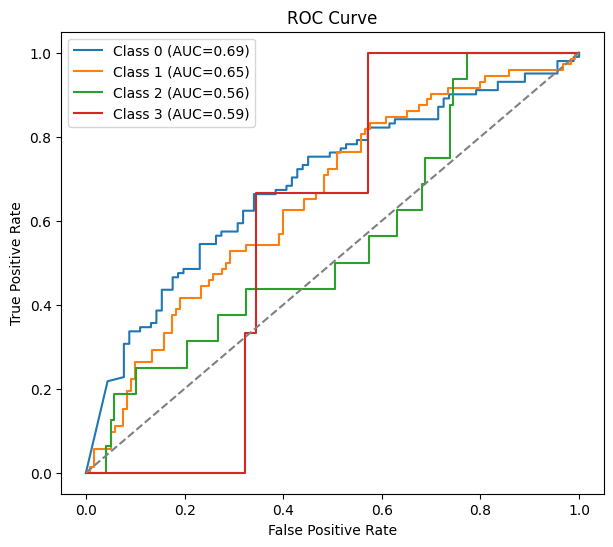

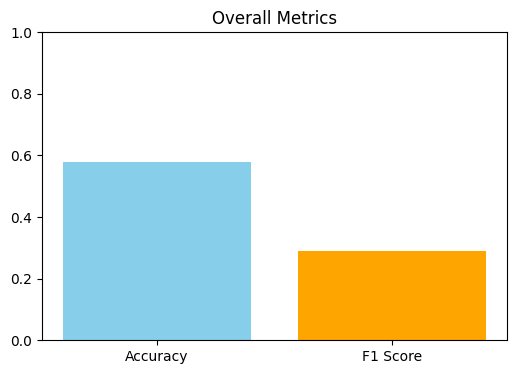

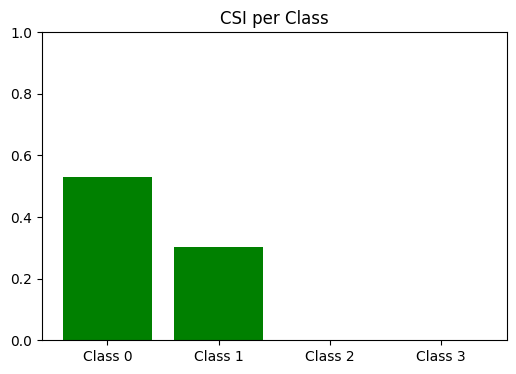

In [10]:
DNN.eval()
all_targets, all_preds, all_probs = [], [], []

with torch.no_grad():
    for features, target in test_loader:
        features = features.to(device)
        target = target.to(device).long()
        outputs = DNN(features)
        
        if outputs.shape[1] == 1:
            # Binary case
            probs = torch.sigmoid(outputs).squeeze(-1)
            preds = (probs > 0.5).long()
        else:
            # Multiclass case
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

        all_targets.append(target.cpu())
        all_preds.append(preds.cpu())
        all_probs.append(probs.cpu())

# Concatenate
all_targets = torch.cat(all_targets).numpy()
all_preds = torch.cat(all_preds).numpy()
all_probs = torch.cat(all_probs).numpy()

# Metrics
cm = confusion_matrix(all_targets, all_preds)
acc = accuracy_score(all_targets, all_preds)
if outputs.shape[1] == 1:
    f1 = f1_score(all_targets, all_preds)
    auc_score = roc_auc_score(all_targets, all_probs)
    csi = cm[1,1] / (cm[1,1] + cm[1,0] + cm[0,1])
else:
    num_classes = outputs.shape[1]
    f1 = f1_score(all_targets, all_preds, average='macro')
    auc_score = roc_auc_score(np.eye(num_classes)[all_targets], all_probs, multi_class='ovr')
    csi = []
    for i in range(num_classes):
        tp = cm[i,i]
        fn = cm[i,:].sum() - tp
        fp = cm[:,i].sum() - tp
        csi.append(tp / (tp + fn + fp) if (tp+fn+fp)>0 else 0)

# Print metrics
print(f"AUC: {auc_score:.4f}, F1: {f1:.4f}, Accuracy: {acc:.4f}")
if outputs.shape[1] > 1:
    for i, c in enumerate(csi):
        print(f"Class {i} CSI: {c:.4f}")
else:
    print(f"CSI: {csi:.4f}")

# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC curve
plt.figure(figsize=(7,6))
if outputs.shape[1] == 1:
    fpr, tpr, _ = roc_curve(all_targets, all_probs)
    plt.plot(fpr, tpr, label=f'AUC={auc_score:.4f}')
else:
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve((all_targets==i).astype(int), all_probs[:,i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Overall metrics bar
metrics = {'Accuracy': acc, 'F1 Score': f1}
plt.figure(figsize=(6,4))
plt.bar(metrics.keys(), metrics.values(), color=['skyblue','orange'])
plt.ylim(0,1)
plt.title('Overall Metrics')
plt.show()

# CSI bar for multiclass
if outputs.shape[1] > 1:
    plt.figure(figsize=(6,4))
    plt.bar([f'Class {i}' for i in range(num_classes)], csi, color='green')
    plt.ylim(0,1)
    plt.title('CSI per Class')
    plt.show()


In [11]:
## Load a previous model
load = True

if load:
    # load_path = "models/Binary_DNN_" # Path to load model
    # load_path = "models/DNN_multiclass_best_accuracy.pt"
    load_path = "models/DNN_multiclass_best_valLoss.pt"
    
    # Load the checkpoint
    checkpoint = torch.load(load_path)
    
    # Restore model weights
    DNN.load_state_dict(checkpoint["DNN_state_dict"])
        
    print(f"Loaded model from {load_path}")

Loaded model from models/DNN_multiclass_best_valLoss.pt
